# **Image Matching Pipeline using SIFT + LightGlue**



Here's a detailed explanation of your **image matching pipeline** using SIFT + LightGlue in PyTorch/Kornia:

---

### **1️⃣ Imports and Setup**

```python
import os, io, requests, cv2, torch, kornia as K, kornia.feature as KF
from kornia_moons.feature import laf_from_opencv_SIFT_kpts
from kornia_moons.viz import draw_LAF_matches
import matplotlib.pyplot as plt
```

* **OpenCV (cv2)**: for SIFT keypoint detection.
* **Kornia / Kornia-Moons**: differentiable computer vision in PyTorch. Includes LightGlue matcher, LAF utilities, and visualization helpers.
* **Torch**: core tensor operations, device handling.
* **Matplotlib**: visualize matches.

---

### **2️⃣ Device Selection**

```python
device = K.utils.get_cuda_or_mps_device_if_available()
print(device)
```

* Chooses GPU if available (CUDA or Apple MPS).
* Speeds up descriptor matching and LightGlue computations.

---

### **3️⃣ LightGlue Matcher and SIFT Initialization**

```python
lg_matcher = KF.LightGlueMatcher("sift").eval().to(device)
num_features = 4096
sift = cv2.SIFT_create(num_features)
```

* **LightGlueMatcher("sift")**: pretrained model for SIFT descriptors.
* **SIFT_create(4096)**: detects up to 4096 features per image.

---

### **4️⃣ Image Loading**

```python
img1 = cv2.cvtColor(cv2.imread(path_a), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(path_b), cv2.COLOR_BGR2RGB)
hw1 = torch.tensor(img1.shape[:2], device=device)
hw2 = torch.tensor(img2.shape[:2], device=device)
```

* Reads and converts OpenCV BGR → RGB.
* Stores height/width for LightGlue scaling.

---

### **5️⃣ Descriptor Normalization: RootSIFT**

```python
def sift_to_rootsift(x: torch.Tensor, eps=1e-6) -> torch.Tensor:
    x = torch.nn.functional.normalize(x, p=1, dim=-1, eps=eps)
    x.clip_(min=eps).sqrt_()
    return torch.nn.functional.normalize(x, p=2, dim=-1, eps=eps)
```

* **RootSIFT** improves SIFT matching by:

  1. L1-normalizing the descriptor.
  2. Taking square root (Hellinger kernel).
  3. L2-normalizing again.

---

### **6️⃣ Detect Keypoints and Compute Descriptors**

```python
with torch.inference_mode():
    kpts1, descs1 = sift.detectAndCompute(img1, None)
    kpts2, descs2 = sift.detectAndCompute(img2, None)
```

* Uses OpenCV SIFT to extract **keypoints** and **descriptors**.

```python
lafs1 = laf_from_opencv_SIFT_kpts(kpts1, device)
lafs2 = laf_from_opencv_SIFT_kpts(kpts2, device)
descs1 = sift_to_rootsift(torch.from_numpy(descs1)).to(device)
descs2 = sift_to_rootsift(torch.from_numpy(descs2)).to(device)
```

* Converts OpenCV keypoints → **Local Affine Frames (LAFs)** compatible with Kornia.
* Converts descriptors to PyTorch and applies **RootSIFT**.

---

### **7️⃣ LightGlue Matching**

```python
dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)
```

* LightGlue produces **tentative matches** between two sets of descriptors using attention-based matching.
* `idxs` contains matched indices: `(idx_img1, idx_img2)`.

```python
print(f"{idxs.shape[0]} tentative matches with SIFT-LightGlue")
```

---

### **8️⃣ Extract Matched Keypoints**

```python
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2

mkpts1, mkpts2 = get_matching_keypoints(KF.get_laf_center(lafs1)[0], KF.get_laf_center(lafs2)[0], idxs.detach().cpu())
```

* Converts LAFs → **keypoint centers**.
* Retrieves matched coordinates for both images.

---

### **9️⃣ Estimate Fundamental Matrix + Inliers**

```python
Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(),
    cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inliers = inliers > 0
```

* **RANSAC-based fundamental matrix estimation**.
* Filters out outliers to keep only **geometrically consistent matches**.

---

### **🔟 Visualize Matches**

```python
draw_LAF_matches(
    lafs1, lafs2,
    idxs.cpu().numpy(),
    img1, img2,
    inliers,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1, 1, 0.2, 0.3),
        "feature_color": None,
        "vertical": False
    },
)
plt.title(f"{inliers.sum()} inliers with SIFT-LightGlue")
```

* Draws tentative matches (yellow) and **inliers** (green) between images.
* LAFs allow visualization of **keypoint affine frames**, not just points.

---

### ✅ **Pipeline Summary**

1. Load images and initialize SIFT.
2. Detect keypoints & compute SIFT descriptors.
3. Convert keypoints → LAFs (affine frames).
4. Convert descriptors → RootSIFT + PyTorch tensors.
5. Run **LightGlue** to get tentative matches.
6. Extract keypoint coordinates from LAFs.
7. Compute **fundamental matrix** to filter inliers.
8. Visualize matches with LAFs and inlier overlay.

This approach combines **classic SIFT features** with **modern LightGlue attention-based matching**, giving robust matches even under scale, rotation, and lighting changes.

---

If you want, I can also **draw a step-by-step diagram** showing this pipeline visually from images → SIFT → LightGlue → inliers. It helps a lot for presentations. Do you want me to do that?

In [1]:
# Using LightGlue via kornia requires kornia>=0.7.2
!pip install kornia==0.7.2
!pip install kornia_moons --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: kornia
    Found existing installation: kornia 0.7.1
    Uninstalling kornia-0.7.1:
      Successfully uninstalled kornia-0.7.1


In [2]:
!mkdir -p .cache/torch/hub/checkpoints
!cp /kaggle/input/lightglue/pytorch/sift/1/sift_lightglue.pth .cache/torch/hub/checkpoints/

In [3]:
import os
import io
import requests
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import torch
from kornia_moons.feature import laf_from_opencv_SIFT_kpts
from kornia_moons.viz import draw_LAF_matches
import numpy as np

In [ ]:
path_a = "/kaggle/input/image-matching-challenge-2024/train/church/images/00017.png"
path_b = "/kaggle/input/image-matching-challenge-2024/train/church/images/00020.png"

In [ ]:
def sift_to_rootsift(x: torch.Tensor, eps=1e-6) -> torch.Tensor:
    x = torch.nn.functional.normalize(x, p=1, dim=-1, eps=eps)
    x.clip_(min=eps).sqrt_()
    return torch.nn.functional.normalize(x, p=2, dim=-1, eps=eps)

device = K.utils.get_cuda_or_mps_device_if_available()
print(device)


lg_matcher = KF.LightGlueMatcher("sift").eval().to(device)

num_features = 4096
sift = cv2.SIFT_create(num_features)

img1 = cv2.cvtColor(cv2.imread(path_a), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(path_b), cv2.COLOR_BGR2RGB)

hw1 = torch.tensor(img1.shape[:2], device=device)
hw2 = torch.tensor(img2.shape[:2], device=device)


with torch.inference_mode():
    kpts1, descs1 = sift.detectAndCompute(img1, None)
    kpts2, descs2 = sift.detectAndCompute(img2, None)
    lafs1 = laf_from_opencv_SIFT_kpts(kpts1, device)
    lafs2 = laf_from_opencv_SIFT_kpts(kpts2, device)
    descs1 = sift_to_rootsift(torch.from_numpy(descs1)).to(device)
    descs2 = sift_to_rootsift(torch.from_numpy(descs2)).to(device)
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)

print(f"{idxs.shape[0]} tentative matches with SIFT-LightGlue")

cpu


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/sift_lightglue.pth" to /root/.cache/torch/hub/checkpoints/sift_lightglue_v0-1_arxiv-pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 185MB/s]


Loaded LightGlue model


/opt/conda/lib/python3.10/site-packages/kornia/feature/integrated.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw1_ = torch.tensor(hw1, device=dev)
/opt/conda/lib/python3.10/site-packages/kornia/feature/integrated.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw2_ = torch.tensor(hw2, device=dev)


32 tentative matches with SIFT-LightGlue


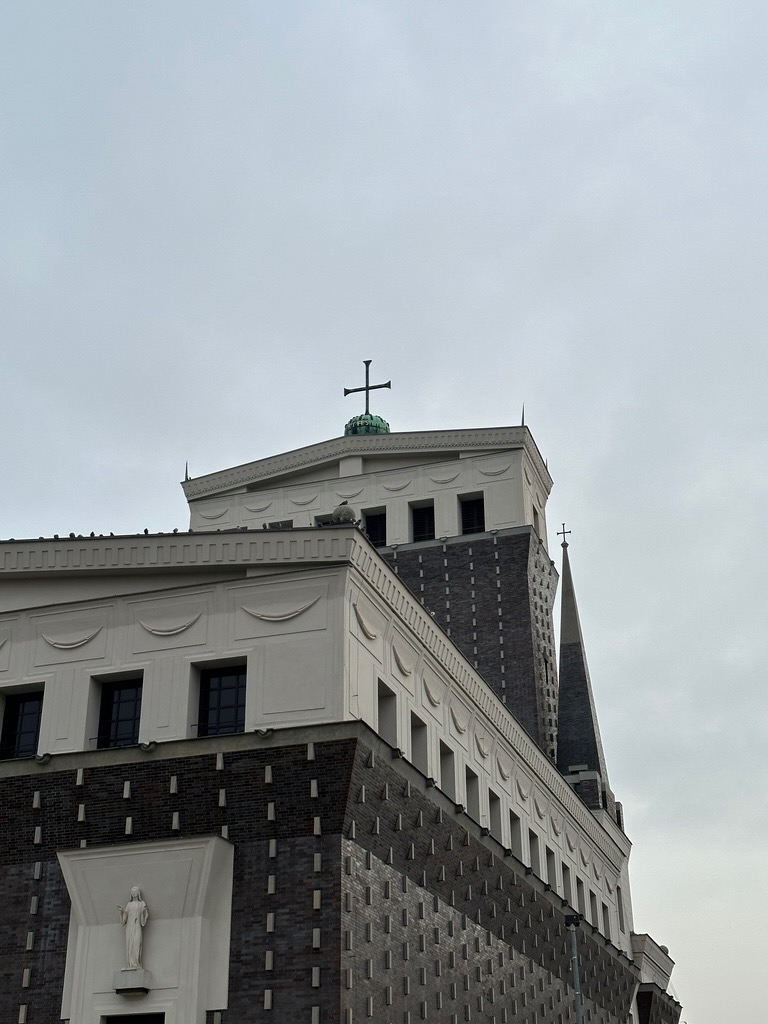

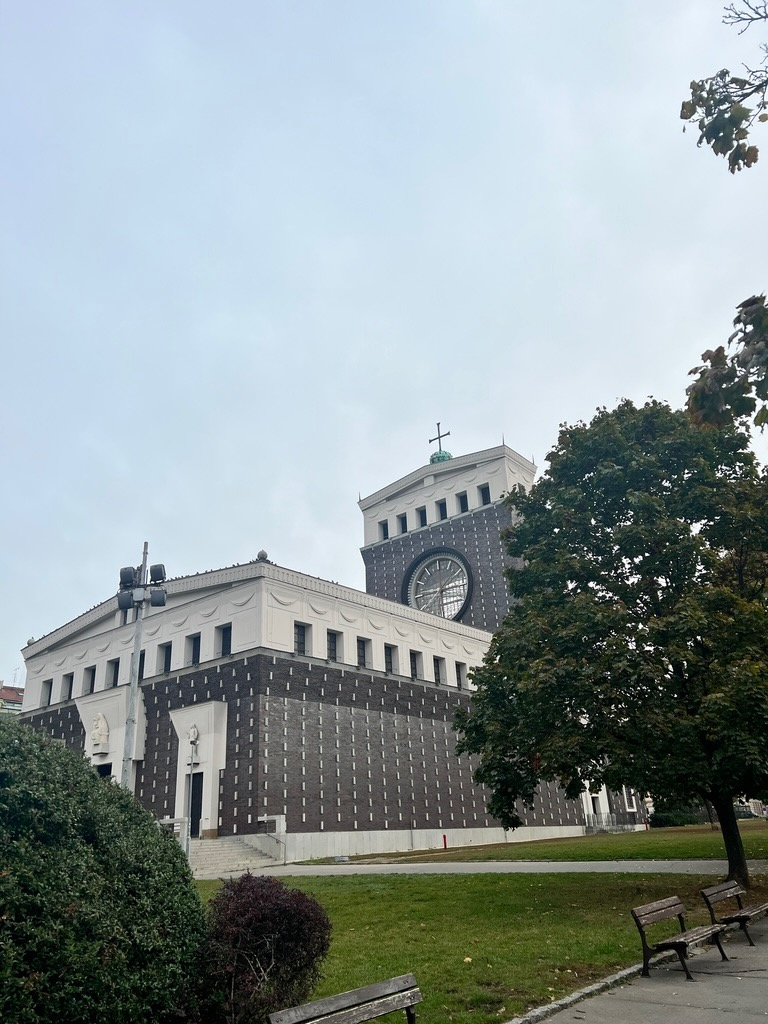

In [ ]:
from PIL import Image
img_a = Image.open(path_a)
img_b = Image.open(path_b)
display(img_a)
display(img_b)

Text(0.5, 1.0, '18 inliers with SIFT-LightGlue')

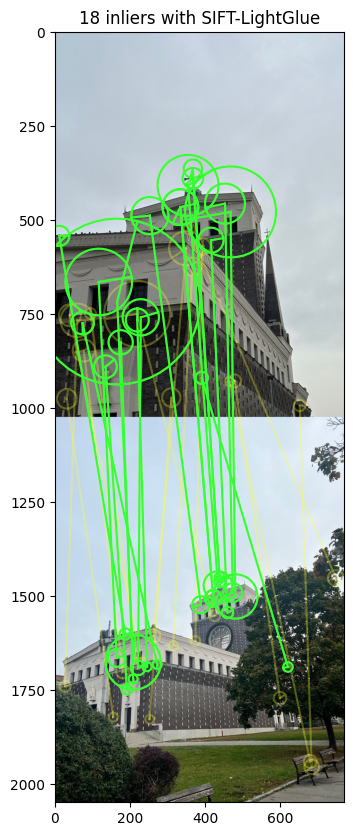

In [ ]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(KF.get_laf_center(lafs1)[0], KF.get_laf_center(lafs2)[0], idxs.detach().cpu())

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inliers = inliers > 0

draw_LAF_matches(
    lafs1, 
    lafs2,
    idxs.cpu().numpy(),
    img1,
    img2,
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), 
               "tentative_color": (1, 1, 0.2, 0.3), 
               "feature_color": None, 
               "vertical": True},
)
plt.title(f"{inliers.sum()} inliers with SIFT-LightGlue")

    Inliers
    Correct correspondences (shown in green)
    Reliable correspondences that are geometrically consistent

    Outliers
    Incorrect correspondences (remain yellow)
    Incorrect correspondences that are geometrically inconsistent

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Change this path to preview any image from your dataset
image_path = "/kaggle/input/image-matching-challenge-2024/train/church/images/00017.png"  # Example path

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()